In [160]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from algbench import read_as_pandas, Benchmark
import re

font = {'family': 'serif', 'size': 11}
matplotlib.rc('font', **font)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = [9, 3.5]

In [206]:
paths = ['g6', 'g8']
optimal_solutions = dict()

combo_results = []
ctg_results = []

for path in paths:
    for row in Benchmark(f'results/classical_benchmark/{path}'):
        if row['parameters']['args']['solver'] == 'combo':
            optimal_solutions[row['parameters']['args']['instance']['name']] = row['result']['objective_value']
    combo_results.append(read_as_pandas(f'results/classical_benchmark/{path}', lambda row: {
        'size': row['parameters']['args']['instance']['size'],
        'elapsed_cycles': row['result']['elapsed_cycles'],
        'elapsed_real_time': (row['result']['elapsed_real_time']),
        'instance': row['parameters']['args']['instance']['name'],
        'objective_value': row['result']['objective_value'],
        'memory_bits': (row['result']['maximum_resident_size_kb']-80000) * 8 * 1024,
    } if row['parameters']['args']['solver'] == "combo" else None))
    ctg_results.append(read_as_pandas(f'results/ctg/{path}', lambda row: {
        'algorithm': 'ctg',
        'algorithm_human_readable': 'CTG',
        'elapsed_cycles': np.average(row['result']['elapsed_cycles']),
        'qtg_estimate_cycles': np.average(
            [it * row['result']['qtg_cycles'] for it in row['result']['total_iterations']]),
        'qtg_estimate_memory_bits': row['parameters']['args']['instance']['size'] +
                               np.log2(row['parameters']['args']['instance']['capacity']) +
                               np.log2(optimal_solutions[row['parameters']['args']['instance']['name']]) +
                               max(row['parameters']['args']['instance']['size'],
                                   np.log2(row['parameters']['args']['instance']['capacity']),
                                   np.log2(optimal_solutions[row['parameters']['args']['instance']['name']])
                                   ) + 1,
        #n + log2(Z) + log2(OPT) + max(n, log2(Z), log2(OPT)) +1
        'success_probability': sum([1 for obj in row['result']['objective_values'] if
                                    obj == optimal_solutions[row['parameters']['args']['instance']['name']]]) / len(
            row['result']['objective_values']),
        'size': row['parameters']['args']['instance']['size'],
        'instance': row['parameters']['args']['instance']['name'],
        'capacity': row['parameters']['args']['instance']['capacity'],
        'max_iter': row['parameters']['args']['alg_params']['max_iter_str'],
        'gap': np.average([(optimal_solutions[row['parameters']['args']['instance']['name']] - obj) / optimal_solutions[
            row['parameters']['args']['instance']['name']] for obj in row['result']['objective_values']]),
        'runtime': row['runtime']
    }))

combo_results = pd.concat(combo_results)
ctg_results = pd.concat(ctg_results)

qtg_results = read_as_pandas(f'results/quantum_benchmark/g2', lambda row: {
    'algorithm': 'ctg',
    'algorithm_human_readable': 'CTG',
    'elapsed_cycles': np.average([measure['cycle_count'] for measure in row['result']['measurements']]),
    'success_probability': sum([1 for measure in row['result']['measurements'] if
                                measure['objective_value'] == optimal_solutions[
                                    row['parameters']['args']['instance']['name']]]) / len(
        row['result']['measurements']),
    'memory_bits': np.average([measure['qubit_count'] for measure in row['result']['measurements']]),
    'size': row['parameters']['args']['instance']['size'],
    'instance': row['parameters']['args']['instance']['name'],
    'capacity': row['parameters']['args']['instance']['capacity'],
    'max_iter': row['parameters']['args']['alg_params']['qtg_iterations_str'],
    'runtime': row['runtime'],
})

ctg_results['g'] = ctg_results.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)
combo_results['g'] = combo_results.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)
qtg_results['g'] = qtg_results.apply(
    lambda row: int(re.match(r'.+\_g\_([0-9]+)\_.+', row['instance']).group(1)), axis=1)

In [188]:
missing_instances = set(combo_results['instance'].unique()) - set(ctg_results['instance'].unique())
print(qtg_results['g'].unique())

[2]


Text(0.5, 1.0, 'Capacity=10000000000, g=[3 6 5 4 2 7 8], max_iter=700 + n^2 / 16')

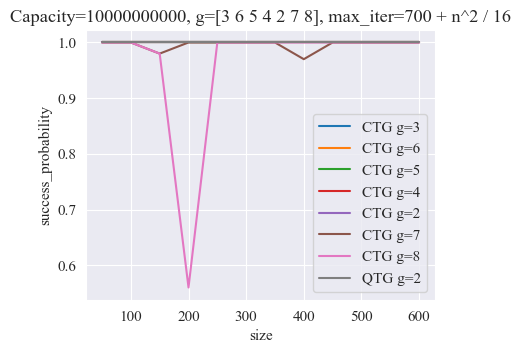

In [193]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
#sns.lineplot(qtg_results, x='size', y='success_probability', ax=ax, label="QTG")
#sns.lineplot(ctg_results, x='size', y='success_probability', ax=ax, label="CTG")
for g in ctg_results['g'].unique():
    sns.lineplot(ctg_results[ctg_results['g'] == g], x='size', y='success_probability', ax=ax, label=f"CTG g={g}")

sns.lineplot(qtg_results, x='size', y='success_probability', ax=ax, label="QTG g=2")

assert len(ctg_results["capacity"].unique()) == 1
assert len(ctg_results["max_iter"].unique()) == 1
ax.set_title(
    f"Capacity={ctg_results['capacity'].unique()[0]}, g={ctg_results['g'].unique()}, max_iter={ctg_results['max_iter'].unique()[0]}")

In [191]:
ctg_results.groupby(['size', 'g']).describe()['success_probability'][['mean', 'max', 'min']]

mean  max  min
size g                
50   2   1.0  1.0  1.0
     3   1.0  1.0  1.0
     4   1.0  1.0  1.0
     5   1.0  1.0  1.0
     6   1.0  1.0  1.0
...      ...  ...  ...
600  4   1.0  1.0  1.0
     5   1.0  1.0  1.0
     6   1.0  1.0  1.0
     7   1.0  1.0  1.0
     8   1.0  1.0  1.0

[84 rows x 3 columns]

In [143]:
ctg_results[ctg_results['g'] == 6].groupby('size').describe()['runtime'][['mean', 'max', 'min']]

,mean,max,min
size,,,
50,3.387871,3.387871,3.387871
100,9.979205,9.979205,9.979205
150,18.938028,18.938028,18.938028
200,33.875272,33.875272,33.875272
250,40.760408,40.760408,40.760408
300,46.815553,46.815553,46.815553
350,79.982158,79.982158,79.982158
400,114.786417,114.786417,114.786417
450,122.999043,122.999043,122.999043


In [144]:
combo_results[combo_results['g'] == 6].groupby('size').describe()['elapsed_real_time'][['mean', 'max', 'min']]

,mean,max,min
size,,,
50,0.27,0.27,0.27
100,0.30,0.30,0.30
150,0.46,0.46,0.46
200,0.83,0.83,0.83
250,1.50,1.50,1.50
300,2.58,2.58,2.58
350,4.63,4.63,4.63
400,7.21,7.21,7.21
450,9.56,9.56,9.56


Text(0.5, 1.0, 'Capacity=1000000, g=[ 3  5  9  4  6  7  8 10]')

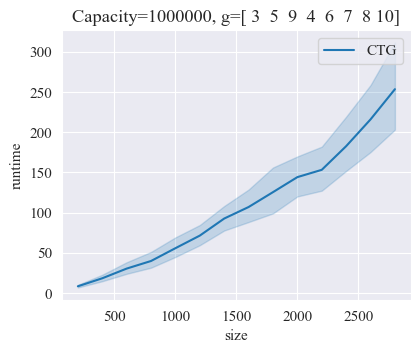

In [108]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.lineplot(ctg_results, x='size', y='runtime', ax=ax, label="CTG")
ax.set_title(f"Capacity={ctg_results['capacity'].unique()[0]}, g={ctg_results['g'].unique()}")

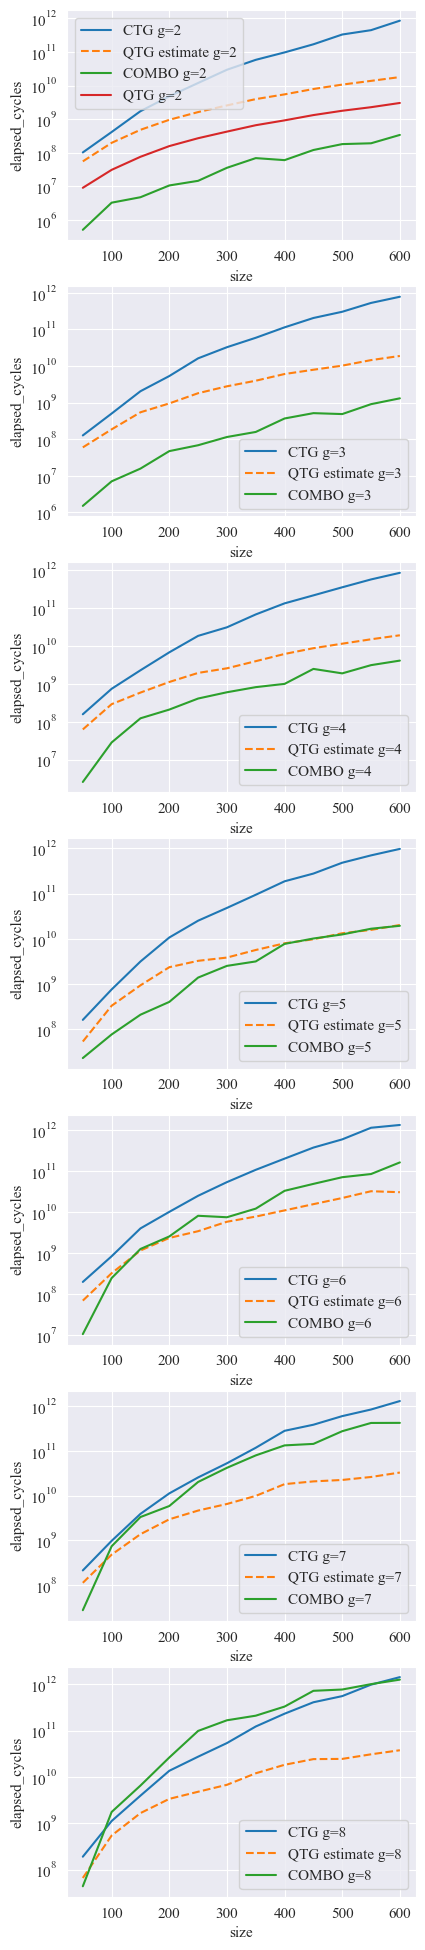

In [190]:
g_values = list(sorted(ctg_results['g'].unique()))
fig, axs = plt.subplots(figsize=(4.5, 3.5 * len(g_values)), nrows=len(g_values))
#sns.lineplot(qtg_results, x='size', y='elapsed_cycles', ax=ax, label="QTG")

for i, g in enumerate(g_values):

    sns.lineplot(ctg_results[ctg_results["g"] == g], x='size',
                 y='elapsed_cycles', ax=axs[i], label=f"CTG g={g}")
    sns.lineplot(ctg_results[ctg_results["g"] == g], x='size',
                 y='qtg_estimate_cycles', ax=axs[i], label=f"QTG estimate g={g}", linestyle='--')
    sns.lineplot(combo_results[combo_results["g"] == g], x='size', y='elapsed_cycles', ax=axs[i], label=f"COMBO g={g}")
    if g == 2:
        sns.lineplot(qtg_results, x='size', y='elapsed_cycles', ax=axs[i], label="QTG g=2")
    #sns.lineplot(combo_results[combo_results["g"] > 4], x='size', y='elapsed_cycles', ax=ax, label="COMBO >4")
    axs[i].set_yscale('log')

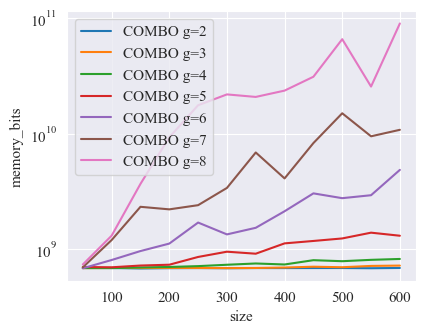

In [199]:
g_values = list(sorted(combo_results['g'].unique()))
fig, ax = plt.subplots(figsize=(4.5, 3.5))

for i, g in enumerate(g_values):
    sns.lineplot(combo_results[combo_results["g"] == g], x='size', y='memory_bits', ax=ax, label=f"COMBO g={g}")

ax.set_yscale('log')

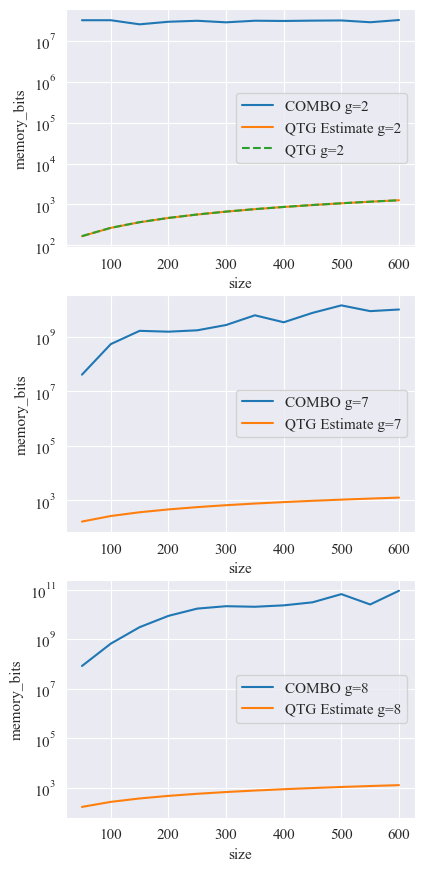

In [208]:
g_values = [2, 7, 8]
fig, axs = plt.subplots(figsize=(4.5, 3.5 * len(g_values)), nrows=len(g_values))

for i, g in enumerate(g_values):
    sns.lineplot(combo_results[combo_results["g"] == g], x='size', y='memory_bits', ax=axs[i], label=f"COMBO g={g}")
    sns.lineplot(ctg_results[ctg_results["g"] == g], x='size', y='qtg_estimate_memory_bits', ax=axs[i], label=f"QTG Estimate g={g}")
    
    if g == 2:
        sns.lineplot(qtg_results, x='size', y='memory_bits', ax=axs[i], label="QTG g=2", linestyle='--')

    axs[i].set_yscale('log')